# Chapter 2

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter2()
# This is needed to render the plots in this chapter
from plots.chapter2 import *

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Rethinking the Training Loop

### Model Training V0

In [3]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v0.py
%run -i model_configuration/v0.py

In [4]:
# %load  model_training/v0.py
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()
    
    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
    
    # Setp 2 - Computes loss
    loss = loss_fn(yhat, y_train_tensor)
    
    # Step 3 - Computes gradients
    loss.backward()
    
    # Step 4 - Update parameters
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


### Training Step

#### Helper Function #1

In [5]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to train mode
        model.train()
        
        # Step 1 - Computes model's predictions - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Update parameters
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside training loop
    return perform_train_step_fn

## Model Configuration V1

In [6]:
# prepare data

%run -i data_preparation/v0.py

let's update model configuration to use the new helper function

In [7]:
%%writefile model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(
    nn.Linear(1, 1)
).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


In [8]:
# load model_configuration v1.py
%run -i model_configuration/v1.py

In [9]:
# check the new train_step function
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

let's update the model training file

In [10]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = []

for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)

Overwriting model_training/v1.py


In [11]:
# run model_training/v1.py
%run -i model_training/v1.py

In [12]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)
                
                
# load training data in the CPU this time
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()
                
train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


### Tensor Dataset

In [14]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


### DataLoader

In [15]:
# mini batch size = 16 . We have only 80 datapoints
train_loader = DataLoader(
        dataset=train_data,
        batch_size=16,
        shuffle=True
)

In [16]:
# retrieve data using next() for iterator
next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

In [17]:
%%writefile data_preparation/v1.py

# Data originally in Numpy
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True,
)

Overwriting data_preparation/v1.py


In [18]:
%run -i data_preparation/v1.py

Incorporate the new mini-batch gradient descent logic

In [19]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

for epoch in range(n_epochs):
    # store loss for each mini-batch
    mini_batch_losses = []
    # iterate through the train_loader
    for x_batch, y_batch in train_loader:
        # the dataset is in the CPU, so are the mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Performs one train step and returns the
        # corresponding loss for this mini-batch
        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
        
    # Computes the average loss over all mini-batches
    # That's the epoch loss
    loss = np.mean(mini_batch_losses)
    
    losses.append(loss)    

Overwriting model_training/v2.py


In [20]:
%run -i model_training/v2.py

In [21]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9698]], device='cuda:0')), ('0.bias', tensor([1.0246], device='cuda:0'))])


In [22]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py
%run -i model_training/v2.py

In [23]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


### Mini Batch Inner Loop

In [24]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
        
    loss = np.mean(mini_batch_losses)
    return loss

In [25]:
%%writefile model_training/v3.py

# defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # mini batch gradient descent
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Overwriting model_training/v3.py


In [26]:
%run -i model_training/v3.py

In [27]:
# Check model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0260], device='cuda:0'))])


### Random Split

In [28]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from Numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(
        dataset=train_data,
        batch_size=16,
        shuffle=True
)

val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting data_preparation/v2.py


In [29]:
# Run Data Preparation
%run -i data_preparation/v2.py

## Evaluation

In [30]:
# Helper function #3

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step
    # in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes predictions - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # No need to compute gradients as we won't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

Define - Model Configuration V2

In [31]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate
lr = 0.1

torch.manual_seed(42)
# Send model to device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function using the model, optimizer and loss_fn
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Create the val_step function using the model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Overwriting model_configuration/v2.py


In [32]:
# Run model configuration V2
%run -i model_configuration/v2.py

Update the training loop to perform evaluation

In [33]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200


losses = []
val_losses = []

for epoch in range(n_epochs):
    # Compute loss
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # Validation - no gradients in validation
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

Overwriting model_training/v4.py


In [34]:
# run model v4
%run -i model_training/v4.py

In [35]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


#### Plotting Losses

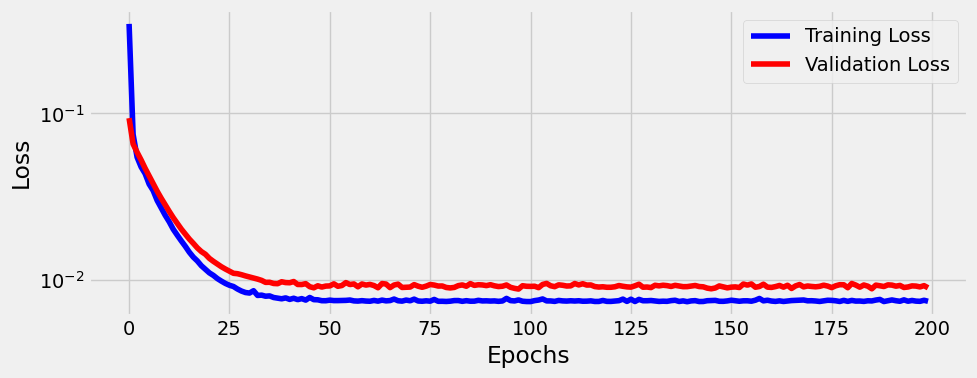

In [36]:
fig = plot_losses(losses, val_losses)

## TensorBoard

In [37]:
# load the TensorBoard notebook extension
# %load_ext tensorboard

Running TensorBoard

In [38]:
#%tensorboard --logdir runs

### Summary Writer

In [39]:
writer = SummaryWriter('runs/test')

Incorporating stats to TensorBoard within the model configuration and training

In [40]:
%run -i data_preparation/v2.py

<Figure size 640x480 with 0 Axes>

In [41]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Create model and send to device
model = nn.Sequential(nn.Linear(1,1)).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train step function using model , loss_fn, and optimizedr
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val step function 
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a SummaryWriter to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# fetches a single mini-batch so we can use add_graph
x_dummy,  y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

Overwriting model_configuration/v3.py


In [42]:
%run -i model_configuration/v3.py

Update the training loop

In [43]:
%%writefile model_training/v5.py

# epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # Compute loss
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # Validation - No gradients in validation
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
        
    # Records train and validation losses for each epoch under tag 'loss'
    writer.add_scalars(
            main_tag='loss',
            tag_scalar_dict={'training': loss,
                            'validation': val_loss},
            global_step=epoch
    )
    
# Closes the writer
writer.close()

Overwriting model_training/v5.py


In [44]:
%run -i model_training/v5.py

In [45]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


## Saving and Loading Models

In [46]:
# Saving Checkpoint
# Need to create a dictionary to save the state of the model and of the optimizer
checkpoint = {
        'epoch': n_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses,
        'val_loss': val_losses
}

# dump into file
torch.save(checkpoint, 'model_checkpoint.pth')

### Resuming Training

In [47]:
# Starting a fresh model - untrained

%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

In [48]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


In [49]:
# Load model
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

model.train() # always use TRAIN for resuming training

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [50]:
# train model
%run -i model_training/v5.py

In [51]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


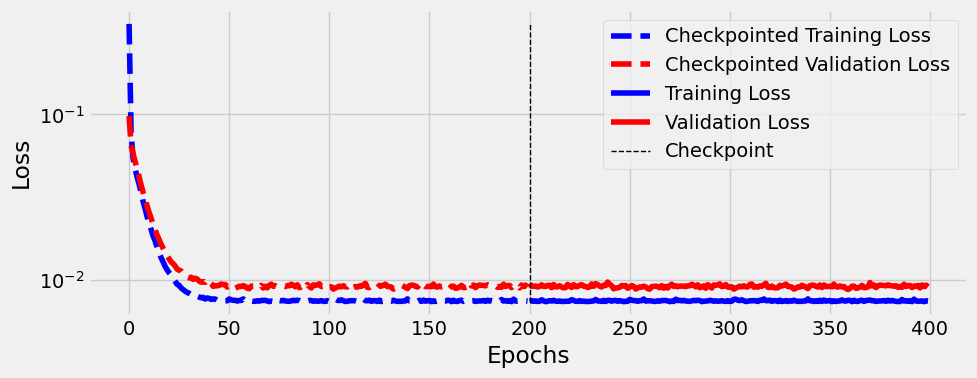

In [52]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

Since we saved a fully trained model, we run it for an extra 200 epochs. The plot shows that the model had already converged to the minima in the first 200 epochs

### Deploying / Making Predictions

In [54]:
# get an untrained model
%run -i model_configuration/v3.py

In [55]:
# load a trained model
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [57]:
# make predictions
new_inputs = torch.tensor([[.20], [.34], [.57]])

model.eval() # Always use EVAL for fully trained models
model(new_inputs.to(device))

tensor([[1.4150],
        [1.6870],
        [2.1340]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Putting it All Together

In [62]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from Numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])
# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [63]:
# %load model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate
lr = 0.1

torch.manual_seed(42)
# Creates model and sends it to device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE Loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates train step function for the model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for the model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression/')
# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

In [64]:
# %load model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # Compute loss
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # records both losses for each epoch under tag 'loss'
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={
                           'training': loss,
                           'validation': val_loss
                       },
                       global_step=epoch)
    
# closes the writers
writer.close()

In [65]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])
